#### Viewpoint estimation

We use backpropagation and Adam optimization to estimate the viewpoint position (x, y, z) for a given scene and lightpoint.

In [1]:
import objects3D
import render
import vector
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch as tr
%matplotlib inline
from IPython.display import display, clear_output
import time

In [2]:
rgb = vector.Vec3

def model(viewpoint):
    
    x = viewpoint[0]
    y = viewpoint[1]
    z = viewpoint[2]

    V = vector.Vec3(x, y, z)

    # lightpoint
    L = vector.Vec3(5, 5, -10)

    # create scene
    scene = [
    objects3D.Sphere(vector.Vec3(.75, .01, .7), .5, rgb(0, 0, 1), V, L),
    objects3D.Sphere(vector.Vec3(-.01, .9,1.05), .6, rgb(.5, .223, .5), V, L),
    objects3D.Sphere(vector.Vec3(-.7, -.2, 1.0), .2, rgb(.5, 1., .5), V, L),
    objects3D.Sphere(vector.Vec3(.3, -.01, .4), .2, rgb(.01, 1., .8), V, L),
    objects3D.Sphere(vector.Vec3(-1.49, .9, 3.2), .6, rgb(.01, 1., .1), V, L),
    ]
    
    # image dimensions
    h = 1400
    w = 1500
    
    # create Renderer object with parameters: image width, image height, scene
    r = render.Renderer(w, h, scene)
    
    # returns Vec3 object with three tensors representing RGB values
    color = render.raytrace(V, (r.Q - V).norm(), r.scene)
    
    # returns tensor of shape (nr_of_channels, height, width)
    img = r.generate_img(color)
    
     # transpose img_tensor to (height, width, nr_of_channels)
    img_tensor_trans = tr.transpose(img, 0, 2)
    img_tensor = tr.transpose(img_tensor_trans, 0, 1)
    
    return img_tensor

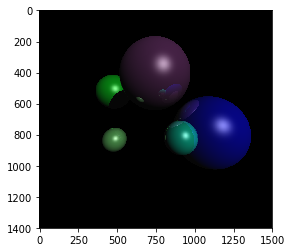

In [3]:
# target viewpoint
target_viewpoint = tr.tensor([0, 0.35, -1])

# target image
target = model(target_viewpoint).detach()

plt.imshow((target/target.max()).detach())

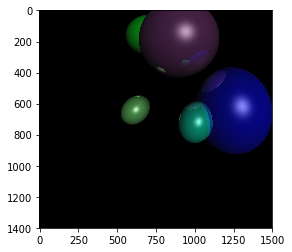

In [4]:
# guess viewpoint
viewpoint = tr.tensor([0.5, 1.0, -1.25], requires_grad=True)
# initial guess
init = model(viewpoint)
# viewpoint optimizer
v_optimizer = tr.optim.Adam([viewpoint], lr=0.01)

plt.imshow((init/init.max()).detach())

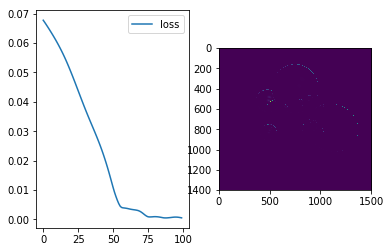

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time

# set up plotting
plt.figure()
imgs, losses, temp = [], [], []

# run 100 Adam iterations
num_iters = 100
for t in range(num_iters):
    v_optimizer.zero_grad()
    img = model(viewpoint)
    
    # Compute the loss function. Here it is L2.
    loss = (img - target).pow(2).mean()

    loss.backward()  
    
    v_optimizer.step()
    
    losses.append(loss.data.item())
    imgs.append((img.data).cpu()) # Record the Gamma corrected image
    temp.append((img - target).pow(2).sum(axis=2).data.cpu())

    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2)
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow((img - target).pow(2).sum(axis=2).data.cpu())
    
    plt.show()

In [6]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow((imgs[0]/imgs[0].max()), animated=True)
def update_fig(i):
    im.set_array(imgs[i]/imgs[i].max())
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(temp), interval=50, blit=True) 

In [8]:
from IPython.display import HTML
HTML(anim.to_jshtml())